In [1]:
from src.model import VAE
from src.trainer import SimCLRTrainer
from src.losses import accurary
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset


from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
from corruption_utils import corruptions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [6]:
majority = list(filter(lambda elem: elem[1] != 5, mnist)) # not 5
minority = list(filter(lambda elem: elem[1] == 5, mnist)) # 5

In [7]:
torch.manual_seed(101)

In [8]:
from src.utils import CMNISTGenerator, CMNIST, random_style_distribution

cmnist_generator = CMNISTGenerator(
    majority, # assign rich styles to non-5 digits
    random_style_distribution(),
)


In [9]:
cmnist = CMNIST(
    cmnist_generator, 
    transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)


Generating dataset: 100%|██████████| 54579/54579 [00:08<00:00, 6122.02item/s]


In [10]:
train_5, test_5 = random_split(minority, [4000, len(minority) - 4000])
train_5_generator = CMNISTGenerator(
    train_5,
    {
        corruptions.identity: 0.3,
        corruptions.stripe: 0.4,
        corruptions.zigzag: 0.3,
        corruptions.canny_edges: 0.0,
    },
)
train_5 = CMNIST(
    train_5_generator, 
    transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

Generating dataset: 100%|██████████| 4000/4000 [00:00<00:00, 8993.44item/s]


In [11]:
(len(minority) - 4000) / len(minority)

0.26212875853163625

In [12]:
train = ConcatDataset([cmnist, train_5])
# train = train_5
train_size = int(0.8 * len(train))
train, valid = random_split(train, [train_size, len(train) - train_size])

In [13]:
test_5_generator = CMNISTGenerator(
    test_5,
    {
        corruptions.identity: 0.0,
        corruptions.stripe: 0.0,
        corruptions.zigzag: 0.0,
        corruptions.canny_edges: 1.0,
    },
)
test_5 = CMNIST(
    test_5_generator, 
    transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

Generating dataset: 100%|██████████| 1421/1421 [00:00<00:00, 4728.73item/s]


In [15]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
test_loader = DataLoader(test_5, batch_size=128, shuffle=False)

### CNN classifier

In [16]:
from src.model import SimpleCNNClassifier
from src.trainer import SimpleCNNTrainer

cnn = SimpleCNNClassifier(n_class=10).to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
trainer = SimpleCNNTrainer(cnn, optimizer, criterion, 5, device)

In [17]:
trainer.fit(26, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 92/92 [00:00<00:00, 522.73it/s]


val_acc=0.918


val-epoch 5: 100%|██████████| 92/92 [00:00<00:00, 557.81it/s]


val_acc=0.972


val-epoch 10: 100%|██████████| 92/92 [00:00<00:00, 562.99it/s]


val_acc=0.976


val-epoch 15: 100%|██████████| 92/92 [00:00<00:00, 531.74it/s]


val_acc=0.977


val-epoch 20: 100%|██████████| 92/92 [00:00<00:00, 502.95it/s]


val_acc=0.979


val-epoch 25: 100%|██████████| 92/92 [00:00<00:00, 528.67it/s]

val_acc=0.976


In [18]:
trainer._valid(test_loader, True, epoch_id=0)

val-epoch 0: 100%|██████████| 12/12 [00:00<00:00, 353.10it/s]

val_acc=0.668


### CD-VAE zero-shot

In [19]:
vae = VAE(total_z_dim=32).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = SimCLRTrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": 0.1, "beta": 0.5, "alpha": [50, 50]},
    verbose_period=5,
    device=device,
)

In [20]:
trainer.fit(31, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 92/92 [00:00<00:00, 104.81it/s]


val_vae_loss=58.212, val_c_loss=0.151, val_s_loss=3.107


val-epoch 5: 100%|██████████| 92/92 [00:00<00:00, 217.46it/s]


val_vae_loss=20.105, val_c_loss=0.074, val_s_loss=3.420


val-epoch 10: 100%|██████████| 92/92 [00:00<00:00, 218.09it/s]


val_vae_loss=15.820, val_c_loss=0.060, val_s_loss=3.452


val-epoch 15: 100%|██████████| 92/92 [00:00<00:00, 213.48it/s]


val_vae_loss=14.210, val_c_loss=0.057, val_s_loss=3.516


val-epoch 20: 100%|██████████| 92/92 [00:00<00:00, 211.02it/s]


val_vae_loss=13.273, val_c_loss=0.057, val_s_loss=3.550


val-epoch 25: 100%|██████████| 92/92 [00:00<00:00, 217.31it/s]


val_vae_loss=12.969, val_c_loss=0.061, val_s_loss=3.563


val-epoch 30: 100%|██████████| 92/92 [00:00<00:00, 205.36it/s]

val_vae_loss=12.388, val_c_loss=0.057, val_s_loss=3.603


In [21]:
vae.eval()
for p in vae.parameters():
    p.requires_grad = False

In [22]:
mu_cs = []
mu_ss = []
labels = []
styles = []
datasource = []
with torch.no_grad():
    for X, label, style in tqdm(train_loader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)
        datasource.append(torch.zeros_like(label).cpu())
    for X, label, style in tqdm(test_loader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)
        datasource.append(torch.ones_like(label).cpu())


100%|██████████| 12/12 [00:00<00:00, 374.99it/s]


In [23]:
mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)
datasource = torch.cat(datasource, dim=0)

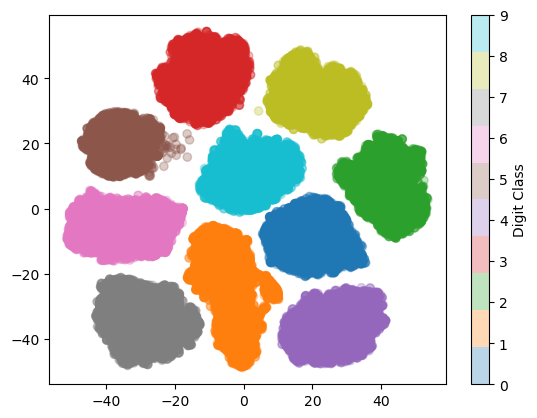

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

from_train = torch.where(datasource == 0)[0]

plt.scatter(mu_cs_tsne[from_train, 0], mu_cs_tsne[from_train, 1], alpha=0.3, 
            c=labels.cpu()[from_train].numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

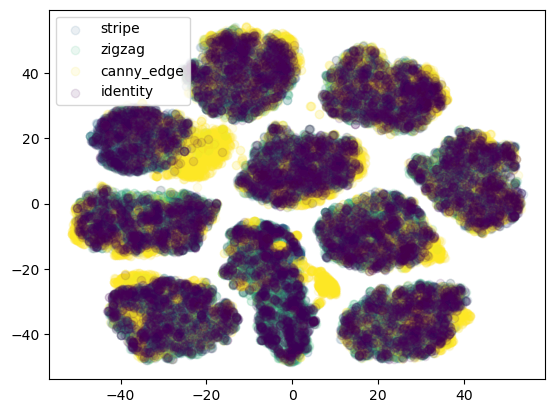

In [27]:
import numpy as np

style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]

fig, ax = plt.subplots()
for g in [1,2,3,0]:
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.1, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [99]:
mu_cs = []
mu_ss = []
labels = []
styles = []
datasource = []
with torch.no_grad():
    for X, label, style in tqdm(valid_loader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)
        datasource.append(torch.zeros_like(label).cpu())
    for X, label, style in tqdm(test_loader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)
        datasource.append(torch.ones_like(label).cpu())


100%|██████████| 12/12 [00:00<00:00, 287.72it/s]


In [100]:
mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)
datasource = torch.cat(datasource, dim=0)

In [101]:
labels[torch.where(datasource == 0)[0]].bincount()

tensor([1200, 1388, 1168, 1237, 1185,  791, 1142, 1269, 1156, 1180],
       device='cuda:0')

In [102]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

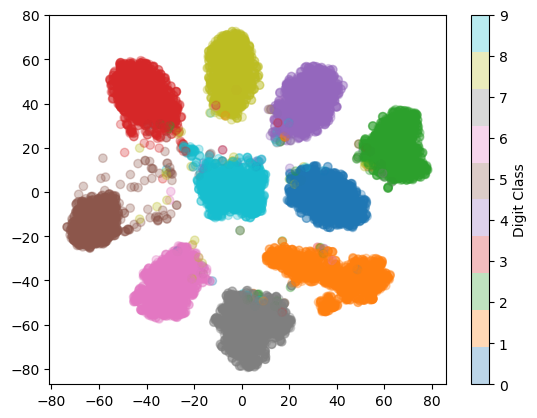

In [103]:
from_valid = torch.where(datasource == 0)[0]
plt.scatter(mu_cs_tsne[from_valid, 0], mu_cs_tsne[from_valid, 1], alpha=0.3, 
            c=labels.cpu()[from_valid].numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

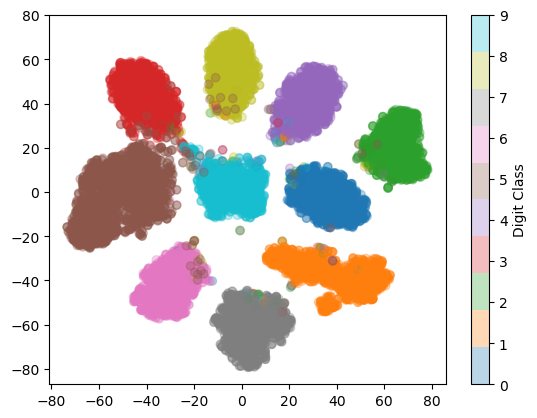

In [104]:
from_valid = torch.where(datasource == 0)
plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

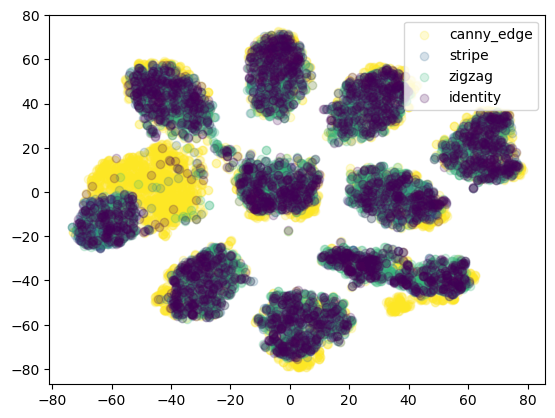

In [105]:
import numpy as np

style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]

fig, ax = plt.subplots()
for g in [3,1,2,0]:
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [106]:
model = torch.nn.Sequential(
    torch.nn.Linear(16, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

In [107]:
EPOCHS = 26
VERBOSE_PERIOD = 5

for epoch in range(EPOCHS):
    verbose = (epoch % VERBOSE_PERIOD) == 0
    model.train()
    with tqdm(train_loader, unit="batch", disable=not verbose) as bar:
        bar.set_description(f"epoch {epoch}")
        for X_batch, y_batch, _ in bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            mu_c, logvar_c = vae.encode(X_batch)[:2]
            logits = model(mu_c)
            # logits = model(torch.cat([mu_c, logvar_c], dim=1))
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            # update running stats
            acc = accurary(logits, y_batch)
            bar.set_postfix(loss=float(loss), acc=float(acc))
    model.eval()
    total_acc = 0
    with torch.no_grad():
        for X_batch, y_batch, _ in tqdm(valid_loader, disable=not verbose):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            mu_c, logvar_c = vae.encode(X_batch)[:2]
            logits = model(mu_c)
            # logits = model(torch.cat([mu_c, logvar_c], dim=1))
            acc = accurary(logits, y_batch)
            total_acc += acc.item()
    if verbose:
        print("val_acc={:.3f}".format(total_acc / len(valid_loader)))
    
            


100%|██████████| 92/92 [00:00<00:00, 423.73it/s]


val_acc=0.985


100%|██████████| 92/92 [00:00<00:00, 421.25it/s]


val_acc=0.987


100%|██████████| 92/92 [00:00<00:00, 331.53it/s]


val_acc=0.987


100%|██████████| 92/92 [00:00<00:00, 327.63it/s]


val_acc=0.987


100%|██████████| 92/92 [00:00<00:00, 331.10it/s]


val_acc=0.987


100%|██████████| 92/92 [00:00<00:00, 330.94it/s]

val_acc=0.987


In [108]:
model.eval()
total_acc = 0
with torch.no_grad():
    for X_batch, y_batch, _ in tqdm(test_loader, disable=not verbose):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        mu_c, logvar_c = vae.encode(X_batch)[:2]
        logits = model(mu_c)
        # logits = model(torch.cat([mu_c, logvar_c], dim=1))
        acc = accurary(logits, y_batch)
        total_acc += acc.item()
if verbose:
    print("val_acc={:.3f}".format(total_acc / len(test_loader)))

100%|██████████| 12/12 [00:00<00:00, 309.82it/s]

val_acc=0.824
